 # MTH8408 : Méthodes d'optimisation et contrôle optimal
 ## Laboratoire 5: Optimisation avec contraintes et calcul variationnel



Travail réalisé par Julien Pallage, 2012861

In [1]:
using Pkg
Pkg.activate("..") #Accède au fichier Project.toml
Pkg.add("NLPModels")
Pkg.add("NLPModels")
Pkg.add("NLPModelsJuMP")
Pkg.add("NLPModelsIpopt")
Pkg.add("ForwardDiff")
Pkg.add("OptimizationProblems")
Pkg.add("Krylov")
Pkg.add("Logging")
Pkg.add("NLPModelsIpopt")
Pkg.add("PDENLPModels")
Pkg.add("Gridap")
Pkg.instantiate()
Pkg.status()

  Activating project at `~/Documents/code/MTH8408-Hiv24`
   Resolving package versions...
  No Changes to `~/Documents/code/MTH8408-Hiv24/Project.toml`
  No Changes to `~/Documents/code/MTH8408-Hiv24/Manifest.toml`
Precompiling project...
  ? PDENLPModels
   Resolving package versions...
  No Changes to `~/Documents/code/MTH8408-Hiv24/Project.toml`
  No Changes to `~/Documents/code/MTH8408-Hiv24/Manifest.toml`
Precompiling project...
  ? PDENLPModels
   Resolving package versions...
  No Changes to `~/Documents/code/MTH8408-Hiv24/Project.toml`
  No Changes to `~/Documents/code/MTH8408-Hiv24/Manifest.toml`
Precompiling project...
  ? PDENLPModels
   Resolving package versions...
  No Changes to `~/Documents/code/MTH8408-Hiv24/Project.toml`
  No Changes to `~/Documents/code/MTH8408-Hiv24/Manifest.toml`
Precompiling project...
  ? PDENLPModels
   Resolving package versions...
  No Changes to `~/Documents/code/MTH8408-Hiv24/Project.toml`
  No Changes to `~/Documents/code/MTH8408-Hiv24/Mani

Status `~/Documents/code/MTH8408-Hiv24/Project.toml`
  [54578032] ADNLPModels v0.7.0
  [6e4b80f9] BenchmarkTools v1.5.0
  [f6369f11] ForwardDiff v0.10.36
⌅ [56d4f2e9] Gridap v0.15.5
  [b6b21f68] Ipopt v1.6.2
  [10dff2fc] JSOSolvers v0.11.1
  [4076af6c] JuMP v1.20.0
  [ba0b0d4f] Krylov v0.9.5
  [40e66cde] LDLFactorizations v0.10.1
  [b964fa9f] LaTeXStrings v1.3.1
  [5c8ed15e] LinearOperators v2.7.0
  [b8f27783] MathOptInterface v1.27.0
  [a4795742] NLPModels v0.20.0
  [f4238b75] NLPModelsIpopt v0.10.1
  [792afdf1] NLPModelsJuMP v0.12.5
  [5049e819] OptimizationProblems v0.7.3
  [80da258d] PDENLPModels v0.3.4
  [91a5bcdd] Plots v1.40.2
⌃ [581a75fa] SolverBenchmark v0.5.5
  [ff4d7338] SolverCore v0.3.7
  [37e2e46d] LinearAlgebra
  [56ddb016] Logging
Info Packages marked with ⌃ and ⌅ have new versions available. Those with ⌃ may be upgradable, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated`


  ? PDENLPModels


In [2]:
using Krylov, LinearAlgebra, Logging, NLPModels, NLPModelsIpopt, Printf, SolverCore, Test

In [3]:
using PDENLPModels, Gridap

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


In [4]:
using BenchmarkTools, SolverCore, LinearOperators
using JSOSolvers, NLPModels # 
using SolverBenchmark
using LinearAlgebra, NLPModels, Printf


## Quelques commentaires en Julia

### Les kwargs: choix optionnels

Dans le projet du dernier labo, une des questions demandait d'ajouter une option pour utiliser la fonction `lsmr` ou `lsqr`. C'est le cas typique d'arguments optionnels:
- On veut proposer un choix par défaut à l'utilisateur, par exemple `lsqr`;
- On veut laisser la possibilité à l'utilisateur de changer;
- On voudrait aussi pouvoir ajouter d'autres par la suite (sans avoir à tout modifier).

In [5]:
function dsol(A, b, ϵ; solver :: Function = lsqr)
    (d, stats) = solver(A, b, atol = ϵ)
    return d
end

dsol (generic function with 1 method)

A noter que l'on donne des valeurs par défaut aux arguments qui apparaissent après le `;`.

## Exercice 1: Pénalité quadratique pour les ADNLPModels

Dans cet exercice, on va étudier une version simple d'une méthode de pénalité quadratique pour les problèmes d'optimisation avec contraintes d'égalité.
```math
min f(x) s.à c(x) = 0.
```
Dans les labos précédents, on a déjà utilisé un NLPModel particulier, le ADNLPModel:

In [5]:
using ADNLPModels, LinearAlgebra, Test
fH(x) = (x[2]+x[1].^2-11)^2 + (x[1]+x[2].^2-7)^2
x0H = [10., 20.]
cH(x) = [x[1]-1]
himmelblau = ADNLPModel(fH, x0H, cH, [0.], [0.]);

Attention: dans toute la suite de l'exercice on suppose que les bornes sur les contraintes `nlp.meta.lcon` et `nlp.meta.ucon` sont 0 pour simplifier.

### Question 1: Transformer un ADNLPModel en un problème pénalisé
Coder la fonction `quad_penalty_adnlp` qui prend en entrée un ADNLPModel, et un paramètre ρ et qui retourne un nouveau ADNLPModel qui correspond au problème sans contrainte:
$$
\min_x f(x) + \frac{\rho}{2}\|c(x)\|^2.
$$
Remarque: on peut accèder aux fonctions f et c par `NLPModels.obj()` et `NLPModels.cons()`.

In [6]:
using NLPModels, NLPModelsIpopt



function quad_penalty_adnlp(nlp :: ADNLPModel, ρ :: Real)
    """
    Returns a new NLPModel with a quadratic penalty term added to the objective function.
    """
    f = x -> obj(nlp,x) + ρ/2 .* norm(cons(nlp,x))^2
    nlp_quad = ADNLPModel(f, nlp.meta.x0)
   return nlp_quad
end


quad_penalty_adnlp (generic function with 1 method)

In [7]:
#Faire des tests pour vérifier que ça fonctionne.

himmelblau_quad = quad_penalty_adnlp(himmelblau, 1)
@test himmelblau_quad.meta.ncon == 0
@test obj(himmelblau_quad, zeros(2)) == 170.5

stats = ipopt(himmelblau_quad);




******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

In [8]:
stats.solution

2-element Vector{Float64}:
 2.9678888605539164
 2.0186523682501782

Ajout d'un autre test similaire.


In [9]:
#Ajouter au moins un autre test similaire avec des contraintes.
using JuMP 
using NLPModels, LinearAlgebra, NLPModelsIpopt

# modifié à partir du code de test_set.jl
@testset "Simple problem v2" begin
    n = 10
    nlp = ADNLPModel(x->dot(x, x), zeros(n),
                     x->[sum(x) - 1], zeros(1), zeros(1))


    quad_nlp = quad_penalty_adnlp(nlp, 1)
    stats = ipopt(quad_nlp)

    dual, primal, status = stats.dual_feas, stats.primal_feas, stats.status
    @test sum(stats.solution) - 1 < 1e-6
    @test dual < 1e-6
    @test primal < 1e-6
    @test status == :first_order
end

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.0000000e-01 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

Test.DefaultTestSet("Simple problem v2", Any[], 4, false, false, true, 1.71113805407431e9, 1.711138056928362e9, false, "/home/julien/Documents/code/MTH8408-Hiv24/lab5_JP/Lab5-notebook.ipynb")

### Question 2: KKT
Coder une fonction `KKT_eq_constraint(nlp :: AbstractNLPModel, x, λ)` qui vérifie si le point `x` avec multiplicateur de Lagrange `λ` satisfait les conditions KKT d'un problème avec contraintes d'égalités.

In [10]:
using ForwardDiff

function KKT_eq_constraint(nlp :: AbstractNLPModel, x, λ, tol=1e-3)
   """
   Check the KKT conditions for a given NLPModel at a given point (x,λ).
   """
   constr = y -> cons(nlp, y)
   ∇c= ForwardDiff.jacobian(constr, x)
   print(∇c)

   ∇f = grad(nlp, x)
   print(∇f)
   
   # Stationarity
   stationarity = ∇f + ∇c' * λ
   print(λ)
   print(stationarity)
   
   # Primal feasibility
   primal_feasibility = constr(x)
   print(primal_feasibility)

   
   # Check all conditions
   if all(abs.(stationarity) .< tol) && all(abs.(primal_feasibility) .< tol) 
      kkt_bool= true
   else
      kkt_bool= false
   end
   return kkt_bool
end

KKT_eq_constraint (generic function with 2 methods)

In [11]:
#test
@testset "Simple problem v2" begin
    n = 10
    nlp = ADNLPModel(x->dot(x, x), zeros(n),
                     x->[sum(x) - 1], zeros(1), zeros(1))

    stats = ipopt(nlp)
    @test KKT_eq_constraint(nlp, stats.solution, stats.multipliers)

    dual, primal, status = stats.dual_feas, stats.primal_feas, stats.status
    @test sum(stats.solution) - 1 < 1e-6
    @test dual < 1e-6
    @test primal < 1e-6
    @test status == :first_order
end

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:       10
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

Test.DefaultTestSet("Simple problem v2", Any[], 5, false, false, true, 1.711138061195937e9, 1.71113806444558e9, false, "/home/julien/Documents/code/MTH8408-Hiv24/lab5_JP/Lab5-notebook.ipynb")

### Question 3: méthode de pénalité quadratique

In [12]:
using NLPModelsIpopt

In [13]:
function quad_penalty(nlp      :: AbstractNLPModel,
                      x        :: AbstractVector; 
                      ϵ        :: AbstractFloat = 1e-3,
                      η        :: AbstractFloat = 1e6, 
                      σ        :: AbstractFloat = 2.0,
                      ρ        :: AbstractFloat = 1.0,
                      max_eval :: Int = 1000, 
                      max_time :: AbstractFloat = 30.,
                      max_iter :: Int = 150
                      )
                      """
                      Solve a nonlinear program with a quadratic penalty method.
                      """
    ##### Initialiser cx et gx au point x;
    cx = cons(nlp,x) # TODO Initialiser la violation des contraintes
    gx = grad(nlp, x) # TODO Initialiser le gradient
    ######################################################
    normcx = normcx_old = norm(cx)


    iter = 0    

    el_time = 0.0
    tired   = neval_cons(nlp) > max_eval || el_time > max_time
    status  = :unknown

    start_time = time()
    too_small  = false
    normdual   = norm(gx) #exceptionnellement on ne va pas vérifier toute l'optimalité au début.
    optimal    = max(normcx, normdual) ≤ ϵ
    
    nlp_quad   = quad_penalty_adnlp(nlp, ρ)

    @info log_header([:iter, :nf, :primal, :status, :nd, :Δ],
    [Int, Int, Float64, String, Float64, Float64],
    hdr_override=Dict(:nf => "#F", :primal => "‖F(x)‖", :nd => "‖d‖"))

    while !(optimal || tired || too_small)

        #Appeler Ipopt pour résoudre le problème pénalisé en partant du point x0 = x.
        #utiliser l'option print_level = 0 pour enlever les affichages d'ipopt.
        stats = ipopt(nlp_quad) #...
        ################################################
      
        if stats.status == :first_order
            ###### Mettre à jour cx avec la solution renvoyé par Ipopt 
            """
            https://jso.dev/SolverCore.jl/dev/reference/#SolverCore.GenericExecutionStats
            """
            x = stats.solution #TODO
            cx = cons(nlp,x) #TODO
            ##########################################################
            normcx_old = normcx
            normcx = norm(cx)
        end
        
        if normcx_old > 0.95 * normcx
            ρ *= σ
        end

        @info log_row(Any[iter, neval_cons(nlp), normcx, stats.status])
        
        nlp_quad   = quad_penalty_adnlp(nlp, ρ)

        el_time      = time() - start_time
        iter   += 1
        many_evals   = neval_cons(nlp) > max_eval
        iter_limit   = iter > max_iter
        tired        = many_evals || el_time > max_time || iter_limit || ρ ≥ η
        ##### Utiliser la réalisabilité dual renvoyé par Ipopt pour `normdual`
        normdual     = norm(stats.dual_feas) # TODO
        ###################################################################
        optimal      = max(normcx, normdual) ≤ ϵ
    end

    status = if optimal 
        :first_order
    elseif tired
        if neval_cons(nlp) > max_eval
            :max_eval
        elseif el_time > max_time
            :max_time
        elseif iter > max_iter
            :max_iter
        else
            :unknown_tired
        end
    elseif too_small
        :stalled
    else
        :unknown
    end

    return GenericExecutionStats(nlp, status = status, solution = x,
                                 objective = obj(nlp, x),
                                 primal_feas = normcx,
                                 dual_feas = normdual,
                                 iter = iter, 
                                 elapsed_time = el_time,
                                 solver_specific = Dict(:penalty => ρ))
end

quad_penalty (generic function with 1 method)

In [14]:
#Faire des tests pour vérifier que ça fonctionne.
stats = quad_penalty(himmelblau, x0H)
@test stats.status == :first_order
@test stats.solution ≈ [1.0008083416169895, 2.709969135758311] atol=1e-2
@test norm(cons(himmelblau, stats.solution)) ≈ 0. atol=1e-3

┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         Δ  
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab5_JP/Lab5-notebook.ipynb:34
┌ Info:      0      69   2.0e+00      first_order
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab5_JP/Lab5-notebook.ipynb:61


This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7433050e+05 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Info:      1     103   1.9e+00      first_order
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab5_JP/Lab5-notebook.ipynb:61
┌ Info:      2     137   1.9e+00      first_order
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab5_JP/Lab5-notebook.ipynb:61
┌ Info:      3     171   1.7e+00      first_order
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab5_JP/Lab5-notebook.ipynb:61
┌ Info:      4     205   1.5e+00      first_order
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab5_JP/Lab5-notebook.ipynb:61
┌ Info:      5     236   1.1e+00      first_order
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab5_JP/Lab5-notebook.ipynb:61
┌ Info:      6     267   5.5e-01      first_order
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab5_JP/Lab5-notebook.ipynb:61
┌ Info:      7     298   2.4e-01      first_order
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab5_JP/Lab5-notebook.ipynb:61
┌ Info:      8     329   1.1e-01      first_order
└ @ Main /home/julien/Docu

Test Passed

In [15]:
print(stats.multipliers)

print((stats.solution[:,1]))

[7.1777085169e-313][1.0008083416168554, 2.709969136165859]

Vérifier que la solution rendue vérifie les conditions KKT avec la fonction de la question précédente.

In [16]:
fH(x) = (x[2]+x[1].^2-11)^2 + (x[1]+x[2].^2-7)^2
x0H = [10., 20.]
cH(x) = [x[1]-1]
himmelblau = ADNLPModel(fH, x0H, cH, [0.], [0.]);
stats = ipopt(himmelblau)
KKT_eq_constraint(himmelblau, stats.solution, stats.multipliers )

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7429000e+05 9.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

true

Les contraintes de KKT sont respectées.

### Devoir - Question 1 - Un problème ADNLProblems

In [17]:
using ADNLPModels, Random 

In [19]:
using OptimizationProblems
using OptimizationProblems.ADNLPProblems
meta = OptimizationProblems.meta
names_pb_vars = meta[(meta.has_equalities_only .== true), [:nvar, :name, :has_equalities_only]];

In [20]:
n = 5
nlp = ADNLPProblems.hs49(n = n)
stats = quad_penalty(nlp, nlp.meta.x0);

┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         Δ  
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab5_JP/Lab5-notebook.ipynb:34
┌ Info:      0      65   8.7e-01      first_order
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab5_JP/Lab5-notebook.ipynb:61


This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       15

Total number of variables............................:        5
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0850006e+02 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Info:      1     129   5.5e-01      first_order
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab5_JP/Lab5-notebook.ipynb:61
┌ Info:      2     193   3.2e-01      first_order
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab5_JP/Lab5-notebook.ipynb:61
┌ Info:      3     254   1.7e-01      first_order
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab5_JP/Lab5-notebook.ipynb:61
┌ Info:      4     315   9.0e-02      first_order
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab5_JP/Lab5-notebook.ipynb:61
┌ Info:      5     373   4.6e-02      first_order
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab5_JP/Lab5-notebook.ipynb:61
┌ Info:      6     431   2.3e-02      first_order
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab5_JP/Lab5-notebook.ipynb:61
┌ Info:      7     486   1.2e-02      first_order
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab5_JP/Lab5-notebook.ipynb:61
┌ Info:      8     541   5.9e-03      first_order
└ @ Main /home/julien/Docu

### Devoir - Question 2 - Benchmark ADNLProblems


In [21]:
ad_problems = (eval(Meta.parse(problem))()  for problem ∈ OptimizationProblems.meta[(meta.has_equalities_only .== true), :name]); 
#ad_problems = (eval(Meta.parse(problem))()  for problem ∈ OptimizationProblems.meta[!, :name])

Base.Generator{Vector{String}, var"#22#23"}(var"#22#23"(), ["BOX2", "aircrfta", "argauss", "avion2", "booth", "britgas", "bt1", "catenary", "chain", "channel"  …  "hs8", "hs80", "hs81", "hs87", "hs9", "hs99", "marine", "mgh01feas", "polygon2", "zangwil3"])

Rouler cette case vient max out la mémoire réservées aux sorties. Il devient donc impossible d'afficher la suite du TP... Je ne comprends pas pourquoi. 

En faisant varier les hyperparamètres, on peut aboutir à une combinaison qui diminue le nombre de calculs. Il faudrait utiliser une méthode d'optimisation de boîte noire pour éviter d'y aller par essai-erreur.

In [ ]:
solvers = Dict(
  :sig_2_rho_1 => model -> quad_penalty(model, model.meta.x0, ϵ=1e-6, η=1e6, σ=2.0, ρ  = 1.0),
  :sig_2_rho_10 => model -> quad_penalty(model, model.meta.x0, ϵ=1e-6, η=1e6, σ=2.0, ρ  = 10.0),
)

stats = bmark_solvers(
  solvers, ad_problems,
  skipif=prob -> (!(equality_constrained(prob.meta))|| get_nvar(prob) > 12 || get_nvar(prob) < 5)); # plus haute dimension fait crash mon ordi...

In [23]:
cols = [:id, :name, :nvar, :objective, :dual_feas, :neval_obj, :neval_grad, :neval_hess, :iter, :elapsed_time, :status,]
header = Dict(
  :nvar => "n",
  :objective => "f(x)",
  :dual_feas => "‖∇f(x)‖",
  :neval_obj => "# f",
  :neval_grad => "# ∇f",
  :neval_hess => "# ∇²f",
  :elapsed_time => "t",
)
for solver ∈ keys(solvers)
    pretty_stats(stats[solver][!, cols], hdr_override=header)
end

## Exercice 2: Calcul Variationnel

Dans cet exercice, on considère le problème de calcul variationnel suivant:
$$
\min \int_0^1 (\dot{x}(t)^2+2x(t)^2)e^t dt, \quad x(0)=0, x(1)=e - e^{-2}
$$

modélisé avec `PDENLPModels`.

In [22]:
function cv_model(n :: Int)

  domain = (0,1) # set the domain
  partition = n
  model = CartesianDiscreteModel(domain,partition) # set discretization
    
  labels = get_face_labeling(model)
  add_tag_from_tags!(labels,"diri1",[2])
  add_tag_from_tags!(labels,"diri0",[1]) # boundary conditions

  order=1
  valuetype=Float64
  reffe = ReferenceFE(lagrangian, valuetype, order)
  V0 = TestFESpace(model, reffe; conformity=:H1, dirichlet_tags=["diri0","diri1"])
  U = TrialFESpace(V0,[0., exp(1)-exp(-2)])

  trian = Triangulation(model)
  degree = 2
  dΩ = Measure(trian,degree) # integration machinery

  # Our objective function
  w(x) = exp(x[1])
  function f(y)
    ∫((∇(y)⊙∇(y) + 2 * y * y) * w) * dΩ
  end

  xin = zeros(Gridap.FESpaces.num_free_dofs(U))
  nlp = GridapPDENLPModel(xin, f, trian, U, V0)
  return nlp
end

cv_model (generic function with 1 method)

### Question 1: Résoudre
Résoudre le NLPModel généré par la fonction `cv_model` pour `n = 16` avec `ipopt` et afficher la solution (attention la solution rendue ne contient pas les valeurs aux bords qu'il faut rajouter).

In [23]:
# TODO
n = 16
stats = ipopt(cv_model(n))

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       44

Total number of variables............................:       15
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.8202747e+02 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

"Execution stats: first-order stationary"

In [25]:
sol = stats.solution
sol = vcat(0, sol, exp(1) - exp(-2) )
println(sol)
println(stats.objective)

[0.0, 0.181963067700128, 0.35428142029136056, 0.5188461331646761, 0.6773749095244438, 0.831435610236028, 0.9824672217813843, 1.1317985765449068, 1.2806651035693912, 1.4302238561349259, 1.5815670345204873, 1.7357341976668703, 1.8937233357803989, 2.056500956855748, 2.2250113233500324, 2.400184960541827, 2.5829465452224323]
20.987074475792042


### Devoir - Question 3:  Convergence en `n`
Afficher sur un même graphique la solution obtenue par `ipopt` pour plusieurs valeurs de `n`.

In [26]:
hist_obj = []
hist_sol = []
hist_n = []
for n in [15,63,127]
    stats = ipopt(cv_model(n))
    append!(hist_obj, stats.objective)
    append!(hist_n, n)
    sol = stats.solution
    sol = vcat(0, sol, exp(1) - exp(-2) )
    append!(hist_sol, [sol])
end

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       41

Total number of variables............................:       14
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.6395311e+02 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

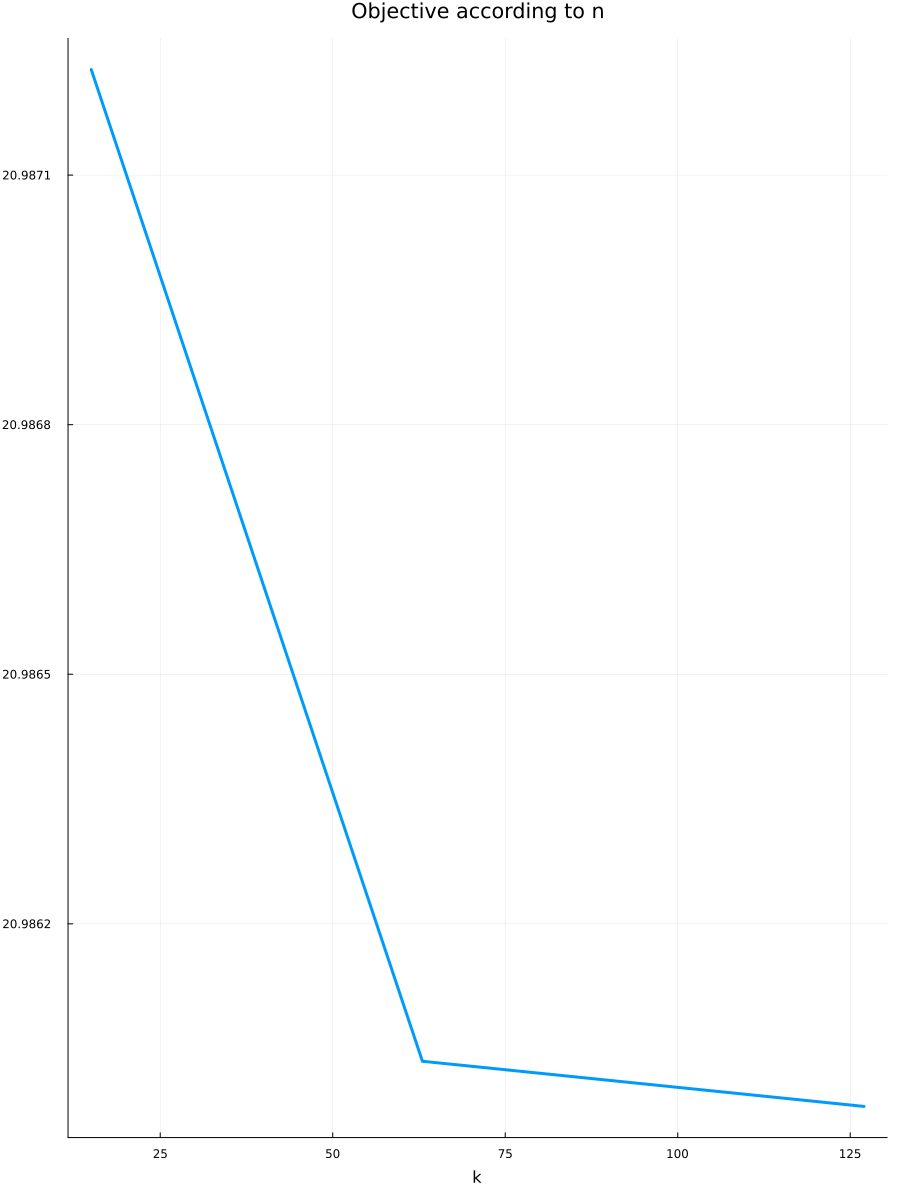

In [27]:
using Plots


p1=plot(hist_n, hist_obj, title="Objective according to n", label="", linewidth=3, xlabel="k",left_margin=3Plots.mm)
plot!(size=(900,1200))
plot(p1, layout=(1,1), legend=true)

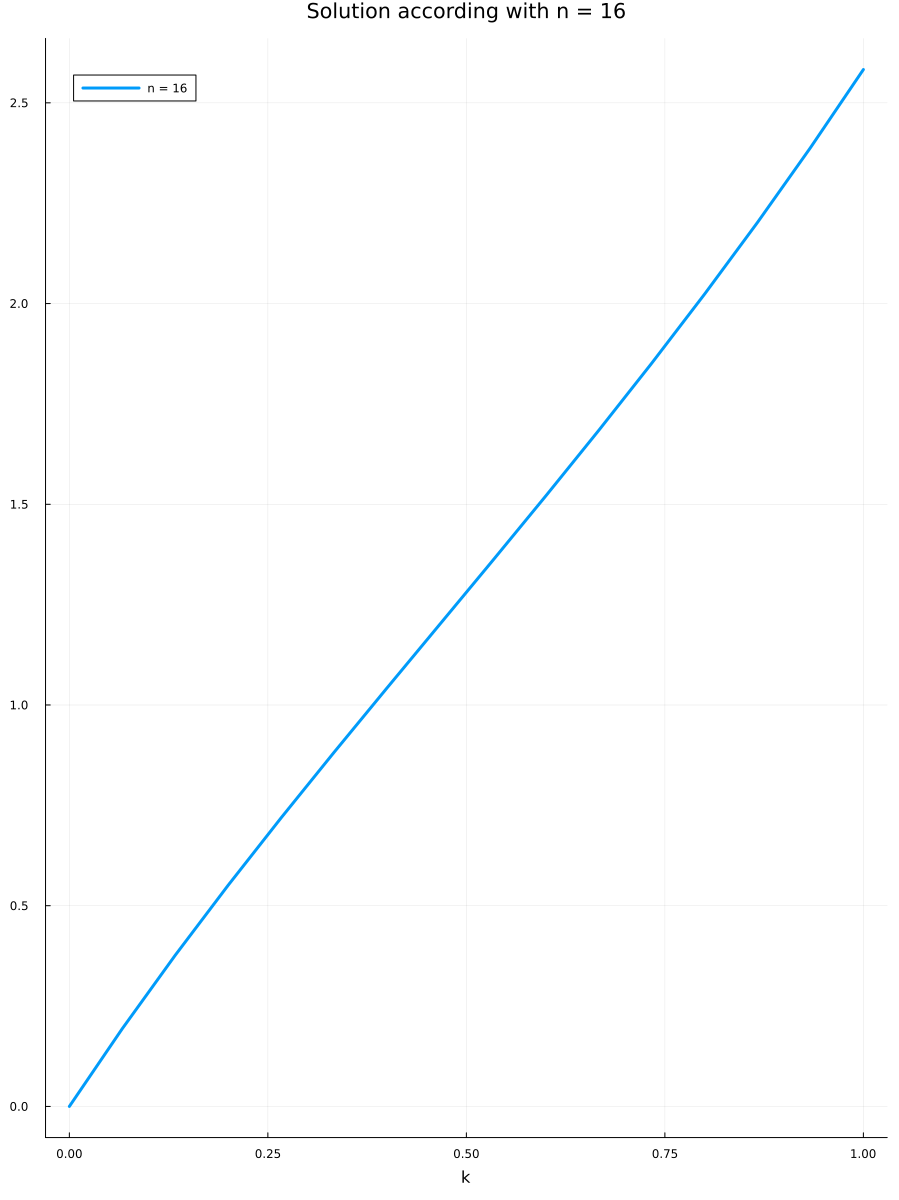

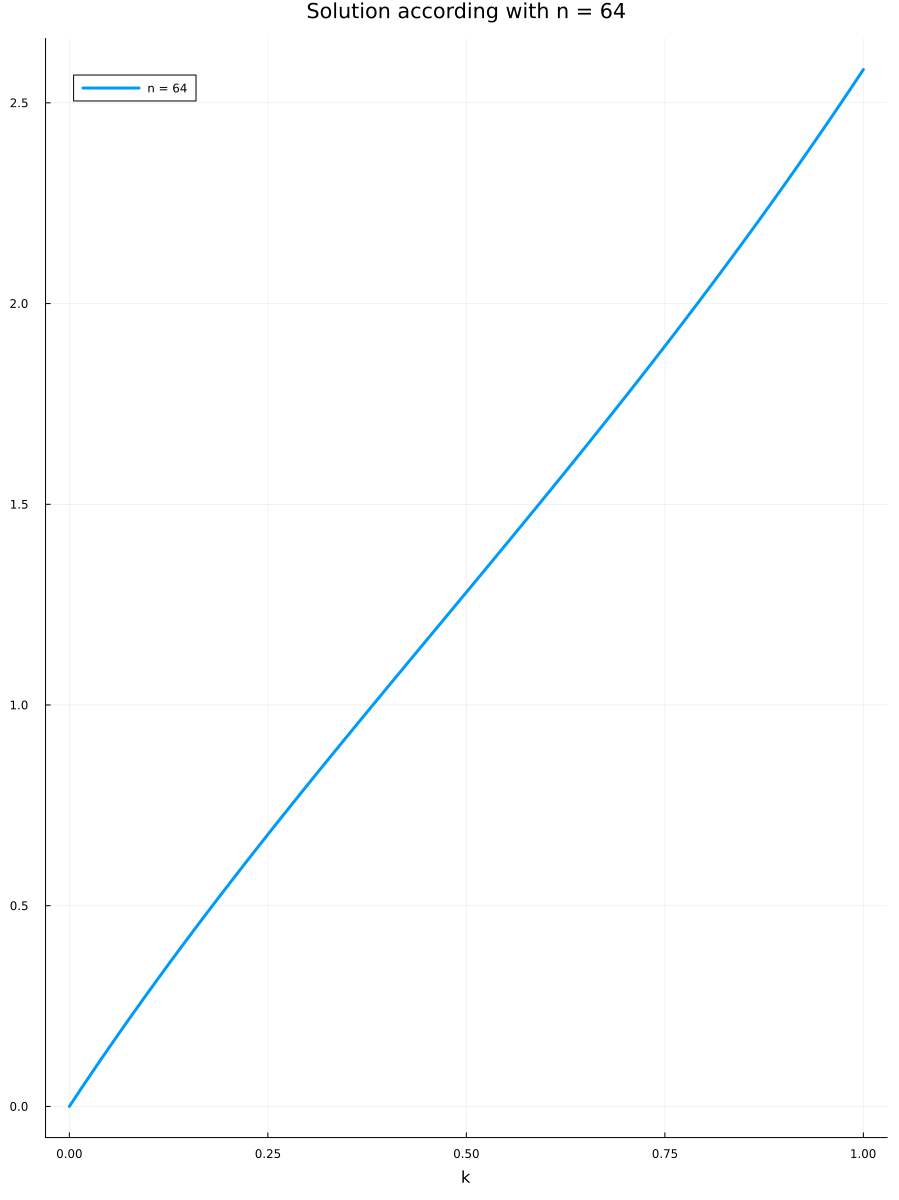

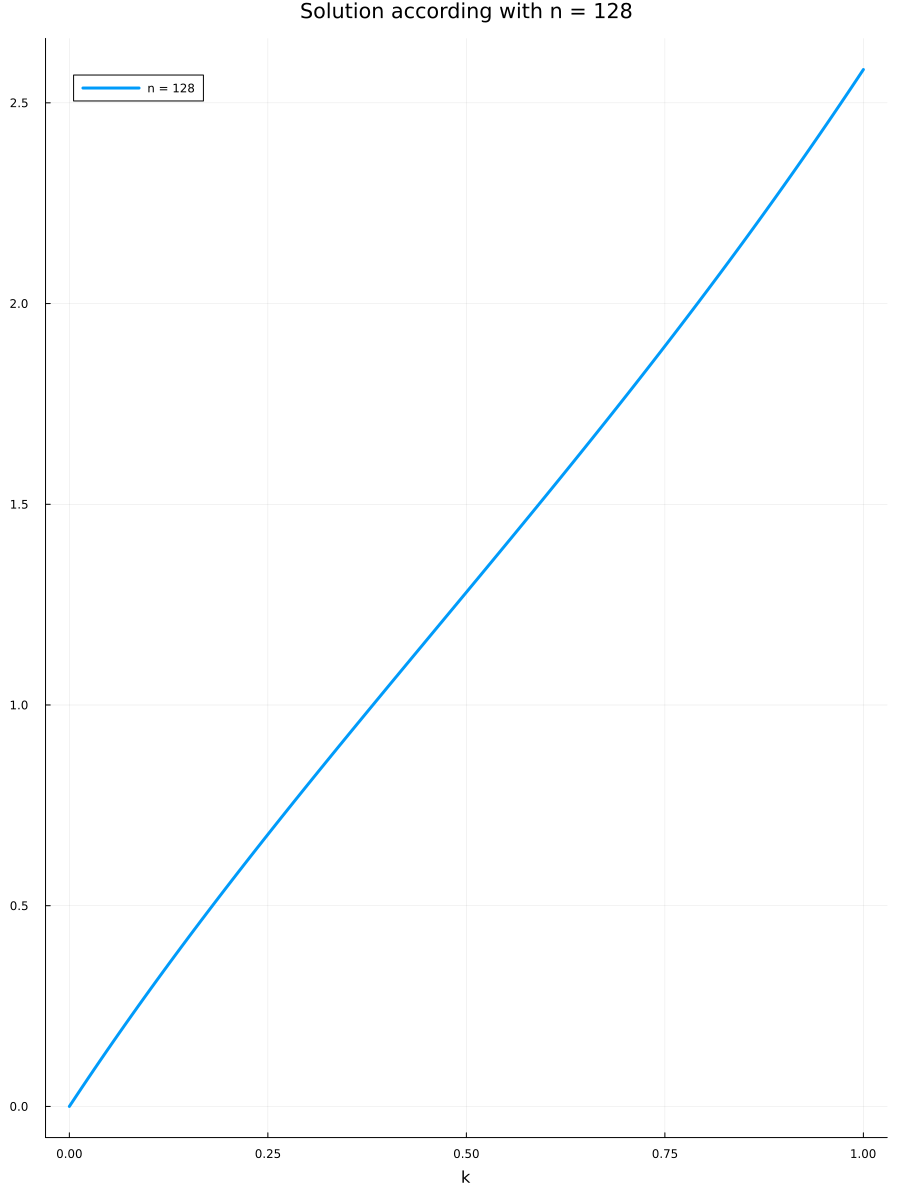

In [28]:
gr()

for n in 1:length(hist_sol)
    leng = length(hist_sol[n])
    t = range(0, 1, length= leng)
    p = plot(t, hist_sol[n], title="Solution according with n = $leng", label= "n = $leng", linewidth=3, xlabel="k",left_margin=3Plots.mm)
    plot!(size=(900,1200))
    display(plot(p, layout=(1,1), legend=true))
end


Je n'arrive pas à mettre chaque courbe sur le même graphique étant donné le nombre de points qui diffère d'une courbe à l'autre.


### Question 3: Comparer à la solution exacte

La solution exacte est $x(t)=e^t - e^{-2t}$ et la valeur optimale est $e^3 - 2e^{-3}+1$.

In [33]:
x = t -> exp.(t) .- exp.(-2 .*t)
opt = exp(3) - 2*exp(-3) + 1

println(opt)
println(abs(opt - hist_obj[end]))


20.98596278645194
1.771869086653055e-5


La solution optimale est presqu'identique à la solution avec 128 points.

In [30]:
leng = length(hist_sol[end])
t = collect(range(0, 1, length= leng))
print(x(t))

[0.0, 0.023529776948816417, 0.04687791384849538, 0.0700487191556386, 0.09304644563216324, 0.11587529130739727, 0.13853940042587098, 0.16104286438103166, 0.18338972263510545, 0.20558396362533304, 0.22762952565679262, 0.24953029778203006, 0.2712901206677064, 0.2929127874484704, 0.31440204456826537, 0.3357615926092695, 0.3569950871086691, 0.37810613936346427, 0.39909831722349565, 0.41997514587288765, 0.4407401086000906, 0.46139664755671017, 0.48194816450530287, 0.5023980215563196, 0.5227495418943702, 0.5430060104939846, 0.5631706748250407, 0.5832467455480261, 0.6032373971993026, 0.623145768866532, 0.6429749648544264, 0.6627280553409828, 0.6824080770243527, 0.7020180337605043, 0.7215608971918286, 0.7410396073668327, 0.7604570733510746, 0.7798161738294764, 0.7991197577001629, 0.8183706446599613, 0.8375716257817065, 0.8567254640834775, 0.875834895089908, 0.8949026273856967, 0.9139313431614499, 0.9329236987519831, 0.9518823251672061, 0.9708098286157171, 0.9897087910212261, 1.00858177053193, 1

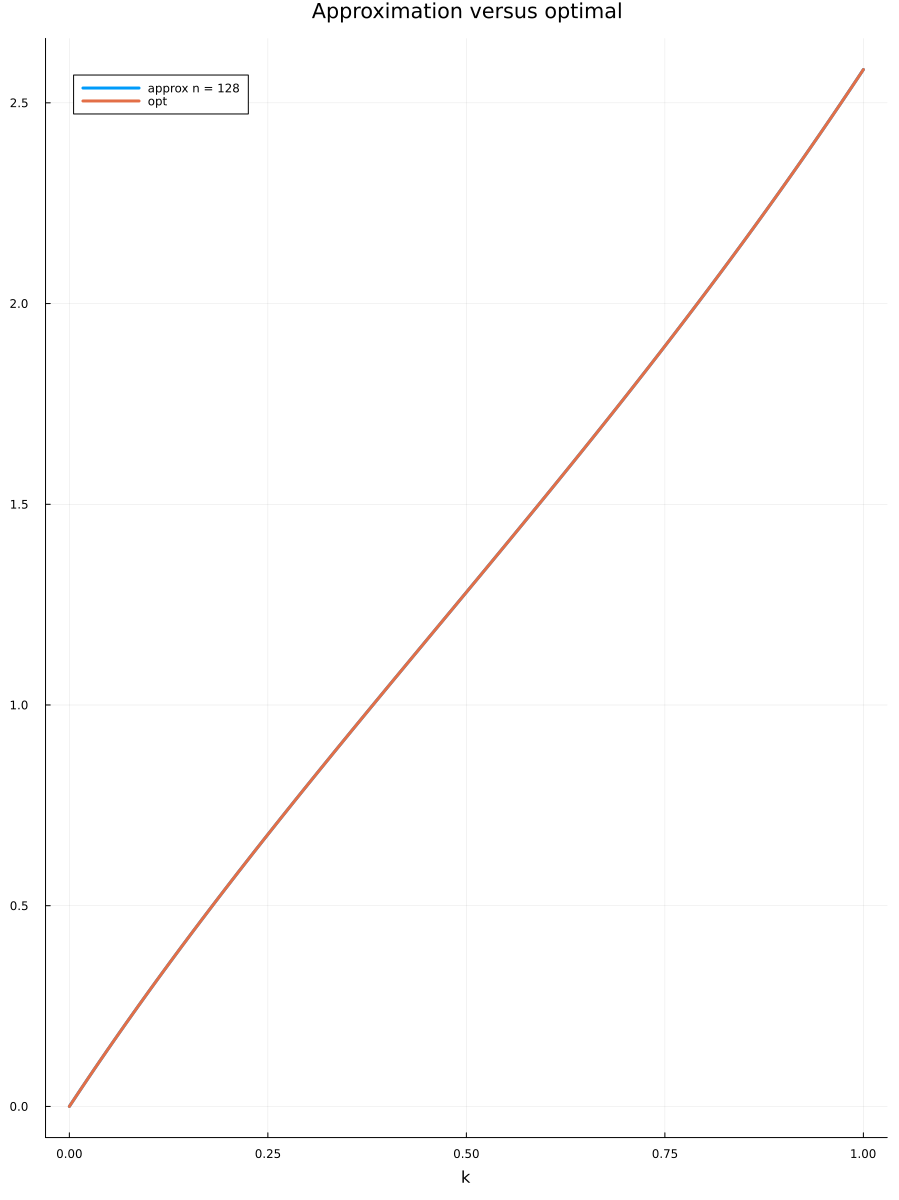

In [31]:
p = plot(t, [hist_sol[end] x(t)], title="Approximation versus optimal", label= ["approx n = $leng" "opt"], linewidth=3, xlabel="k",left_margin=3Plots.mm)
plot!(size=(900,1200))
plot(p, layout=(1,1), legend=true)

Les courbes se chevauchent.
